## NeuroDOT_py Full Processing Script <br>
This script combines the Preprocessing and Reconstruction pipelines. A set of sample Data files exist in the /Data directory of the toolbox.For each data set, there is an example *.pptx with selected visualizations. The NeuroDOT_Tutorial_Full_Data_Processing.pptx uses NeuroDOT_Data_Sample_CCW1.mat. <br>


In [9]:
# Import necessary libraries
import sys,os
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy.matlib as nm
import json
import mat73

from matplotlib.pyplot import colorbar, colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Add NeuroDOT library to the path
sys.path.insert(0,'./neuro_dot')

from Visualizations import viz
from Spatial_Transforms import sx4m
from Temporal_Transforms import tx4m 
from Light_Modeling import lmdl
from File_IO import io
from Analysis import anlys
from Matlab_Equivalent_Functions import matlab
from Reconstruction import recon

In [13]:
participant_data = "/Users/Yash/Documents/neurodot workshop july 2023/data/subjects/sub-01/ses-01/scan-01/nirs/NeuroDOT_Data_Sample_CCW1.mat"
params_file = "/Users/Yash/Documents/neurodot workshop july 2023/data/subjects/sub-01/params.txt"
saveImages = 'yes'

In [14]:
if saveImages == 'no':
    print('SAVED IMAGES IS SET TO NO. NO IMAGES WILL BE SAVED.')
    
z = ""
with open(params_file) as f:
    for line in f: 
        z = z + line.strip()
params = json.loads(z)
# If you want to change an individual or a few params, just follow syntax below (NOTE: make changes before 'print' statements to confirm dictionary updates): 
# params['bthresh'] = 0.075
print("Params being used: \n")
print(params)

Params being used: 

{'bthresh': 0.075, 'det': 1, 'highpass': 1, 'lowpass1': 1, 'ssr': 1, 'lowpass2': 1, 'DoGVTD': 1, 'resample': 1, 'omega_hp': 0.02, 'omega_lp1': 1, 'omega_lp2': 0.5, 'freqout': 1, 'rstol': 0.001, 'DQC_ONLY': 0, 'omega_resample': 1, 'dt': 36, 'tp': 16}


In [15]:
## Load data
# data_path = os.path.join(os.path.dirname(sys.path[0]),'Data')
data = io.loadmat(participant_data)['data'] 
__info = io.loadmat(participant_data)['info'] # adding __info makes info private, so any changes will be function-specific
flags = io.loadmat(participant_data)['flags']
tag = participant_data.split("/")[-1].split("_")[-1][:-4]
E = None
MNI = None

In [16]:
# Set parameters for A and block length for quick processing examples
if 'CW' in participant_data or 'OUT' in participant_data:
    A_fn='/Project/A_matrices/A_AdultV24x28.mat' #  Sensitivity Matrix (path to A matrix on your machine! this file is too large to go in the GitHub repo being worked out of)
    params['dt']=36                     # Block length
    params['tp']=16                     # Example (block averaged) time point
if 'IN' in participant_data:
    A_fn='/Project/A_matrices/A_AdultV24x28.mat' # Sensitivity Matrix
    params['dt']=36                     # Block length
    params['tp']=32                     # Example (block averaged) time point

if  'HW' in participant_data or 'RW' in participant_data or 'GV' in participant_data or 'CV' in participant_data or 'OV' in participant_data:
    A_fn='/Project/A_matrices/A_Adult_96x92.mat'  # Sensitivity Matrix
    params['dt']=30                     # Block length
    params['tp']=16                     # Example (block averaged) time point

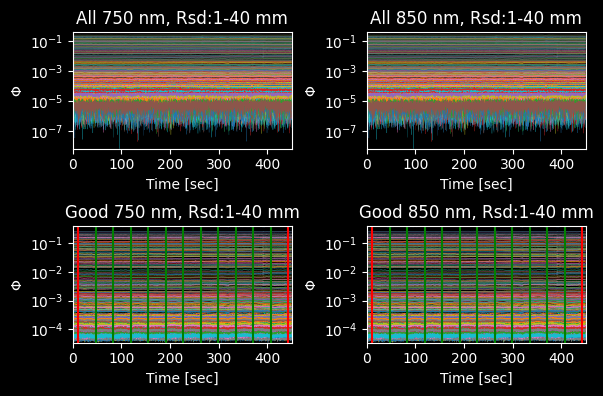

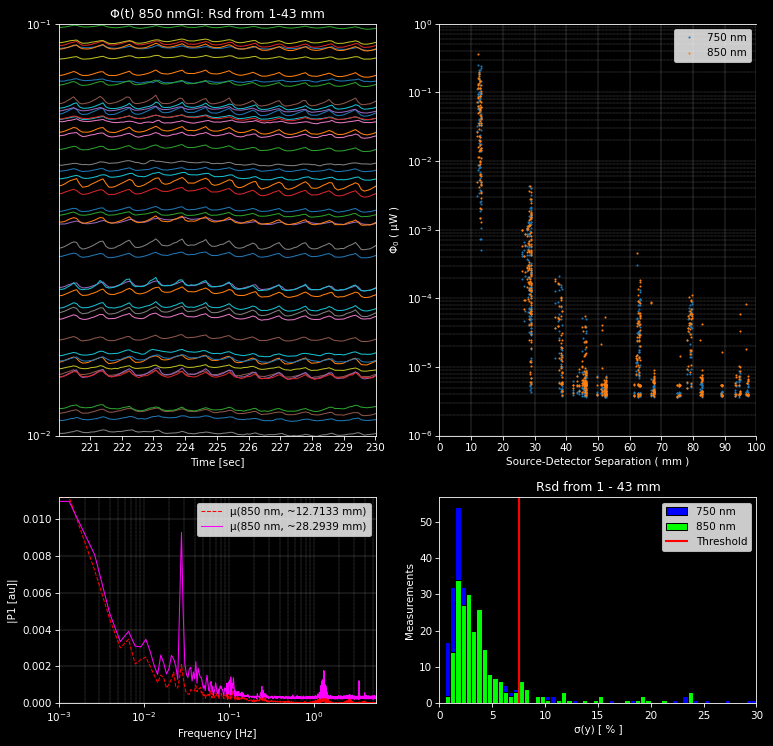

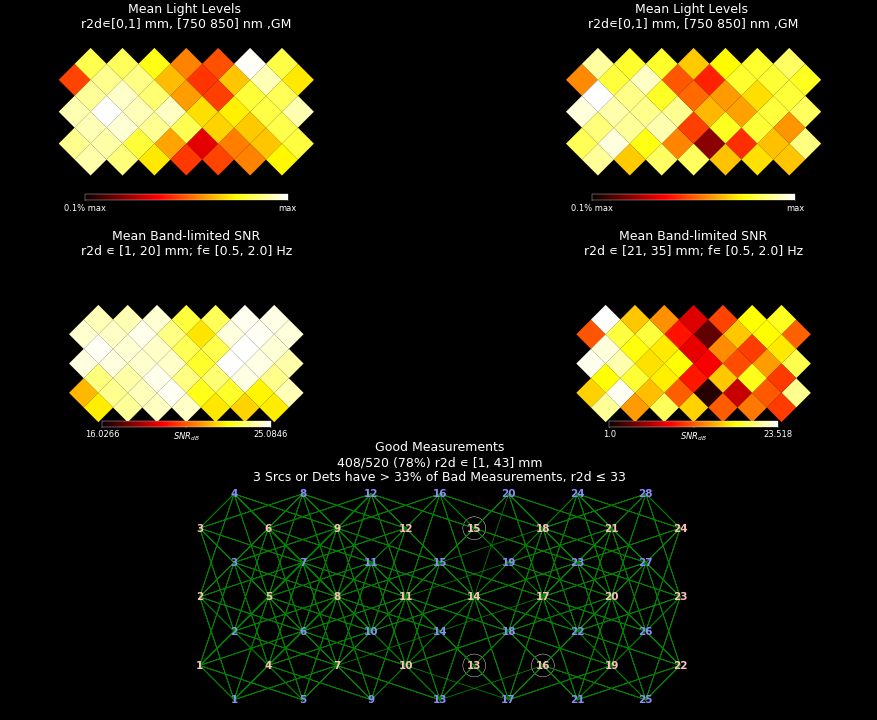

In [17]:
params_timetraces = copy.deepcopy(params)
params_datametrics_2 = copy.deepcopy(params)
viz.Plot_RawData_Time_Traces_Overview(data,__info,params_timetraces)     # Time traces
viz.Plot_RawData_Metrics_II_DQC(data,__info,params_datametrics_2)        # Spectrum, falloff, and good signal metric
__info_out = viz.Plot_RawData_Cap_DQC(data,__info,params)                # Cap-relevant views

In [18]:
## Logmean Light Levels
lmdata = tx4m.logmean(data)[0]

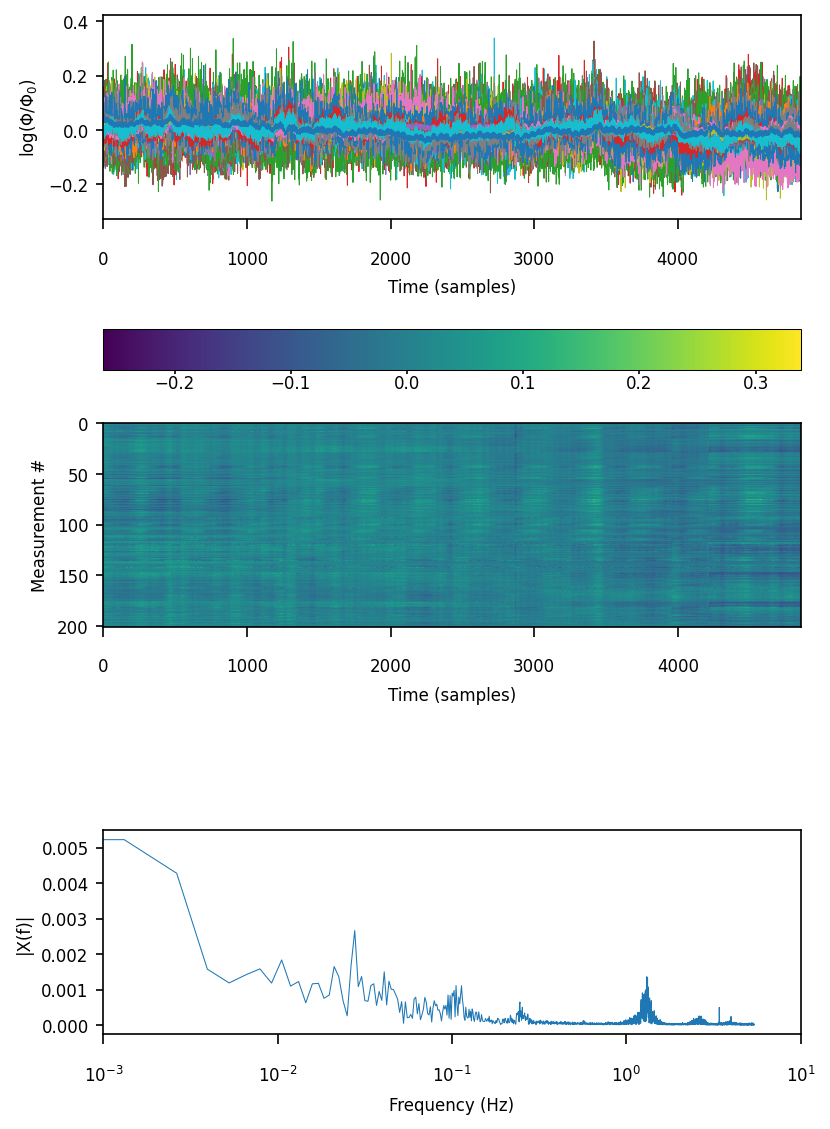

In [19]:
## Detect Noisy Channels
info = anlys.FindGoodMeas(lmdata, __info, params['bthresh']) 

# Example visualization
keep = np.logical_and(np.logical_and(np.where(info['pairs']['WL'] == 2,1,0), np.where(info['pairs']['r2d'] < 40,1,0)), info['MEAS']['GI']) # measurements to include

fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lmdata[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(lmdata[keep,:]),1.25*np.amax(abs(lmdata[keep,:]))])
ax1.set_xlim([0, len(lmdata[keep][1])])

im2 = ax2.imshow(lmdata[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(lmdata[keep,:]),1), (len(np.mean(np.transpose(lmdata[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%",  
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)

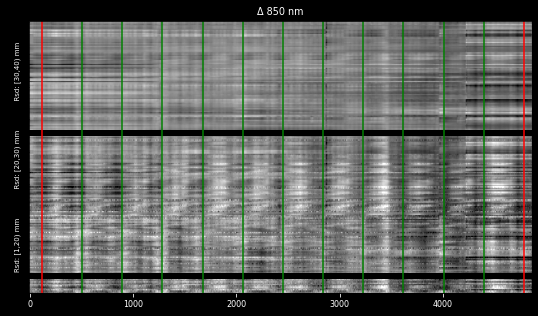

In [20]:
## Show nn1, nn2, nn3 (plots)
viz.nlrGrayPlots_220324(lmdata,info)

(-0.13175501337557569, 0.2002219987153482)

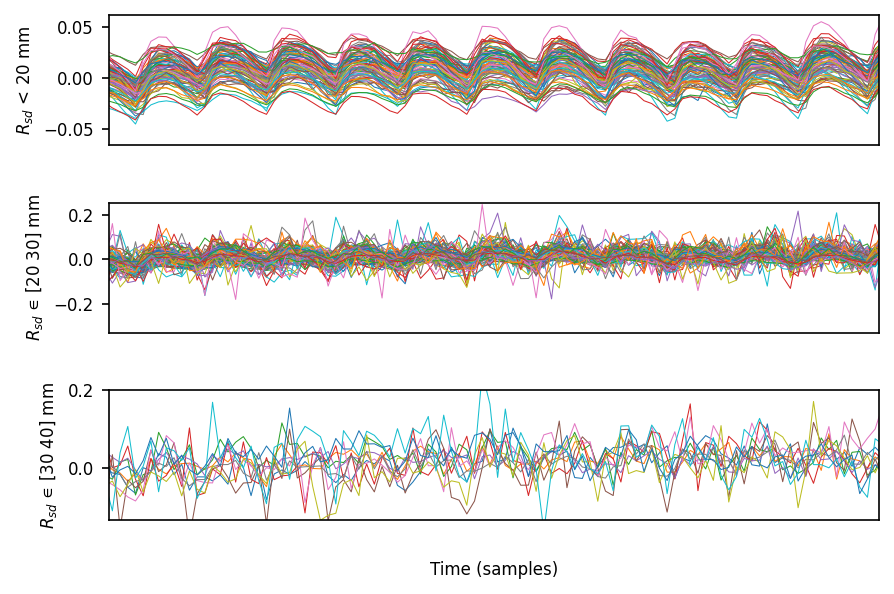

In [21]:
# Visualize Data after Logmean and Cleaning Measurements at different S-D distances
keepd1=np.logical_and(np.logical_and(info['MEAS']['GI'], np.where(info['pairs']['r2d']<20,1,0)), np.where(info['pairs']['WL']==2,1,0))
keepd2=np.logical_and(np.logical_and(np.logical_and(info['MEAS']['GI'], np.where(info['pairs']['r2d']>=20,1,0)), np.where(info['pairs']['r2d']<30,1,0)), np.where(info['pairs']['WL']==2,1,0))
keepd3=np.logical_and(np.logical_and(np.logical_and(info['MEAS']['GI'], np.where(info['pairs']['r2d']>=30,1,0)), np.where(info['pairs']['r2d']<40,1,0)), np.where(info['pairs']['WL']==2,1,0))

fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lmdata[keepd1,:]), linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$ < 20 mm')
ax1.set_xlim([np.shape(lmdata[keepd1,:])[1]/2,(np.shape(lmdata[keepd1,:])[1]/2 +100)])
ax1.set_ylim([np.amin(lmdata[keepd1,:])*0.5, np.amax(lmdata[keepd1,:])*0.5])
ax2.plot(np.transpose(lmdata[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([np.shape(lmdata[keepd2,:])[1]/2,(np.shape(lmdata[keepd2,:])[1]/2 +100)])
ax2.set_ylim([np.amin(lmdata[keepd2,:])*1.25, np.amax(lmdata[keepd2,:])*0.75])

ax3.plot(np.transpose(lmdata[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([np.shape(lmdata[keepd3,:])[1]/2,(np.shape(lmdata[keepd3,:])[1]/2 +100)])
ax3.set_ylim([np.amin(lmdata[keepd1,:]), np.amax(lmdata[keepd3,:])*0.75])


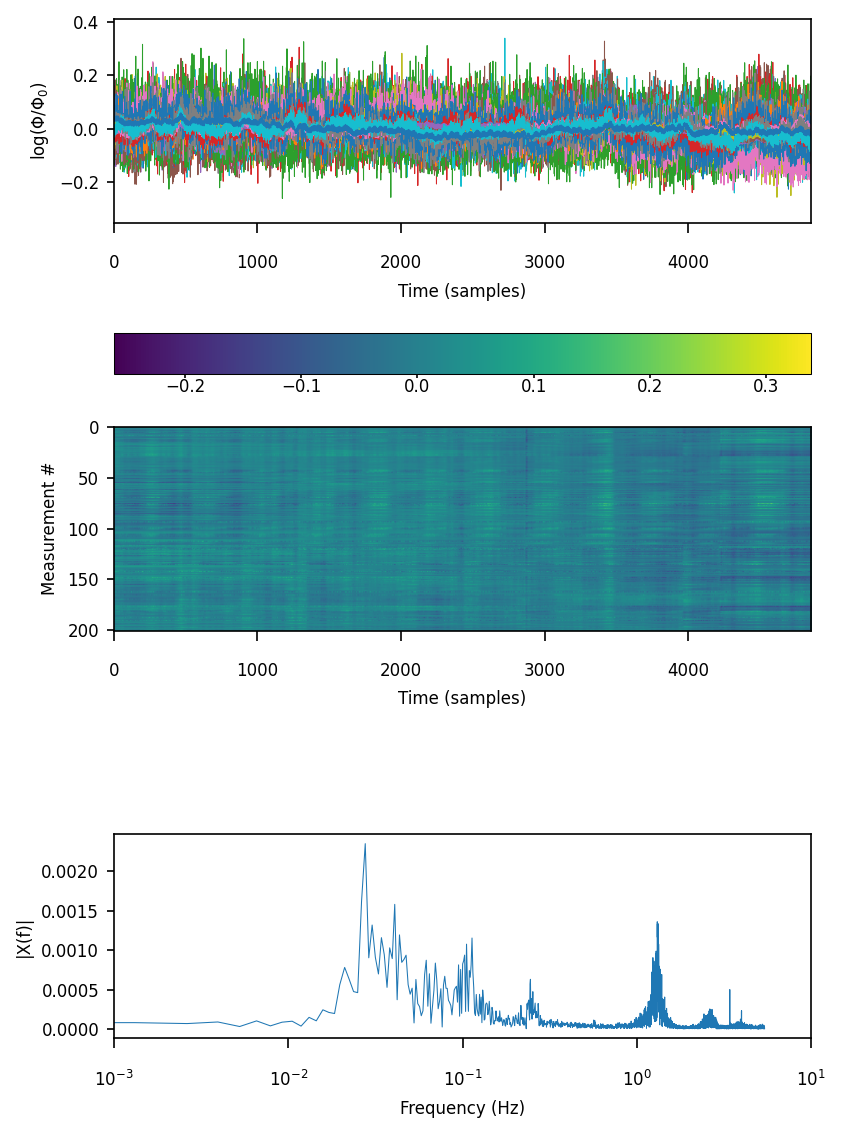

In [22]:
## Detrend and High-pass Filter the Data
ddata = tx4m.detrend_tts(lmdata)

# High Pass Filter
hpdata = tx4m.highpass(ddata, 0.02, info['system']['framerate'])
# hpdata = highpass_py(ddata, 0.05, info.system.framerate); % problematic cutoff frequency example

fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lmdata[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(hpdata[keep,:]),1.25*np.amax(abs(hpdata[keep,:]))])
ax1.set_xlim([0, len(hpdata[keep][1])])

im2 = ax2.imshow(lmdata[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(hpdata[keep,:]),1), (len(np.mean(np.transpose(hpdata[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%",  
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)


(-0.2256131468999632, 0.18501016332212025)

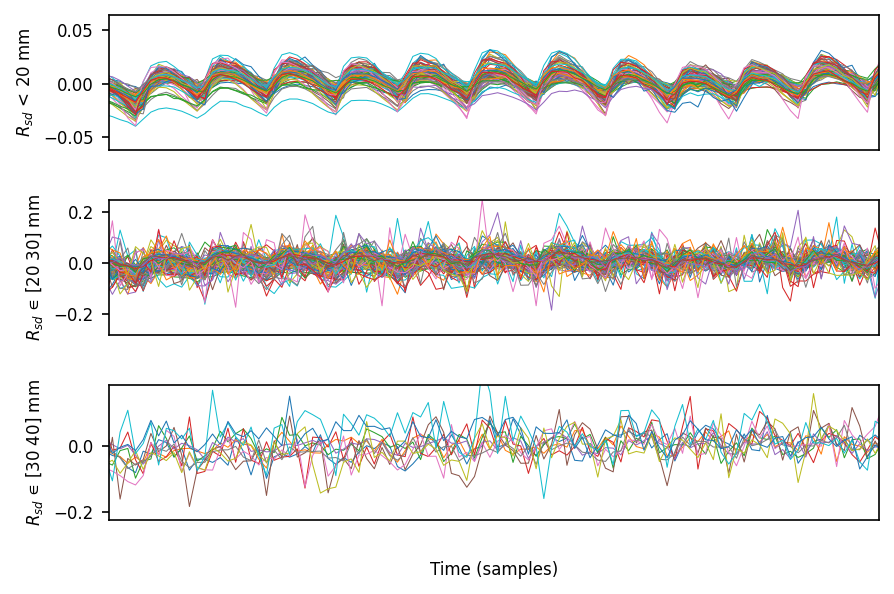

In [23]:
# Visualize Data after High-Pass Filtering at different S-D distances
fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(hpdata[keepd1,:]), linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$ < 20 mm')
ax1.set_xlim([np.shape(hpdata[keepd1,:])[1]/2,(np.shape(hpdata[keepd1,:])[1]/2 +100)])
ax1.set_ylim([np.amin(hpdata[keepd1,:])*0.5, np.amax(hpdata[keepd1,:])*0.75])

ax2.plot(np.transpose(hpdata[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([np.shape(hpdata[keepd2,:])[1]/2,(np.shape(hpdata[keepd2,:])[1]/2 +100)])
ax2.set_ylim([np.amin(hpdata[keepd2,:]), np.amax(hpdata[keepd2,:])*0.75])


ax3.plot(np.transpose(hpdata[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([np.shape(hpdata[keepd3,:])[1]/2,(np.shape(hpdata[keepd3,:])[1]/2 +100)])
ax3.set_ylim([np.amin(hpdata[keepd3,:]), np.amax(hpdata[keepd3,:])*0.75])

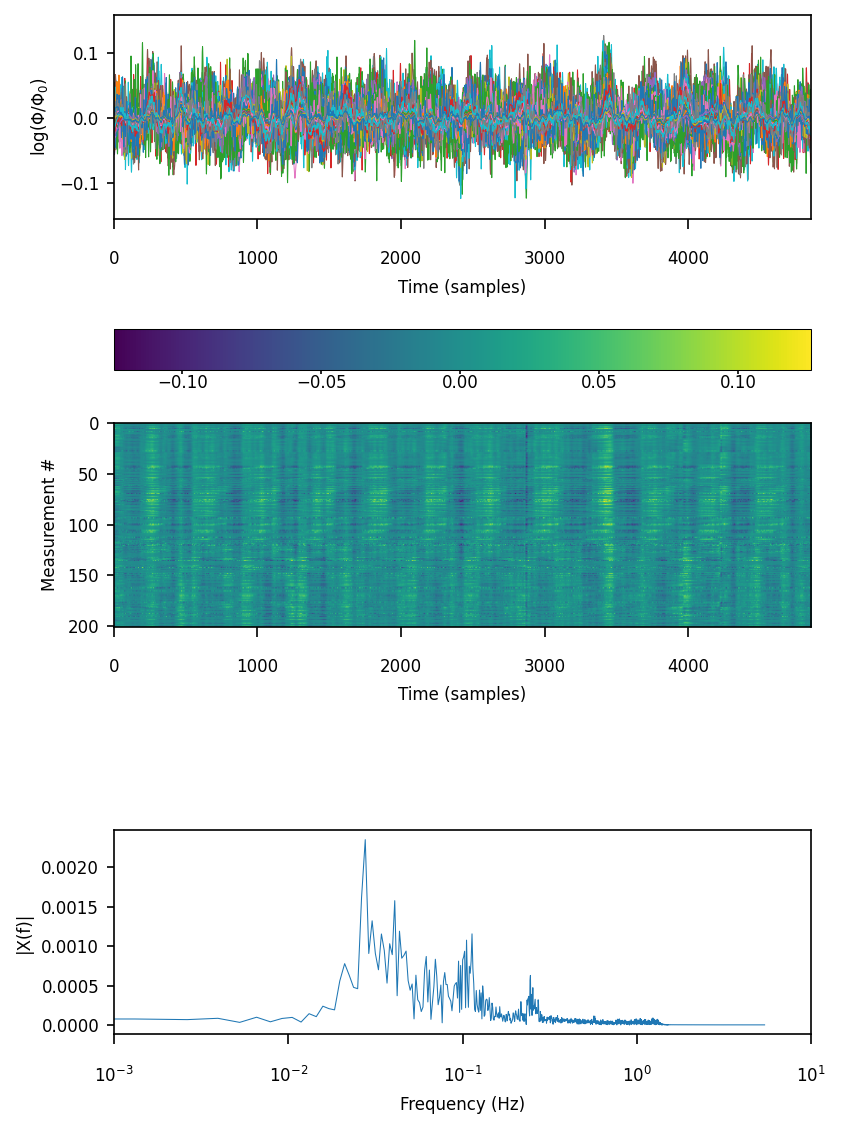

In [24]:
## Low Pass Filter 1
lp1data = tx4m.lowpass(hpdata, 1, info['system']['framerate'])

fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lp1data[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(lp1data[keep,:]),1.25*np.amax(abs(lp1data[keep,:]))])
ax1.set_xlim([0, len(lp1data[keep][1])])

im2 = ax2.imshow(lp1data[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(lp1data[keep,:]),1), (len(np.mean(np.transpose(lp1data[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%",  
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)

(-0.09892906099107018, 0.09467798370550269)

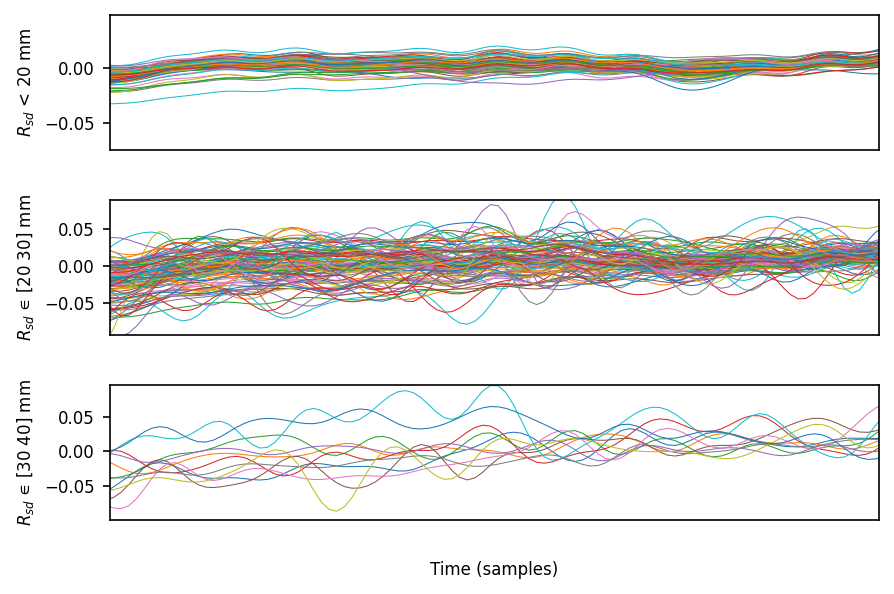

In [25]:
# Visualize Data after Low-Pass Filtering at different S-D distances
fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lp1data[keepd1,:]), linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$ < 20 mm')
ax1.set_xlim([np.shape(lp1data[keepd1,:])[1]/2,(np.shape(lp1data[keepd1,:])[1]/2 +100)])
ax1.set_ylim([np.amin(lp1data[keepd1,:])*0.8, np.amax(lp1data[keepd1,:])*0.75])


ax2.plot(np.transpose(lp1data[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([np.shape(lp1data[keepd2,:])[1]/2,(np.shape(lp1data[keepd2,:])[1]/2 +100)])
ax2.set_ylim([np.amin(lp1data[keepd2,:])*0.75, np.amax(lp1data[keepd2,:])*0.75])

ax3.plot(np.transpose(lp1data[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([np.shape(lp1data[keepd3,:])[1]/2,(np.shape(lp1data[keepd3,:])[1]/2 +100)])
ax3.set_ylim([np.amin(lp1data[keepd3,:])*0.8, np.amax(lp1data[keepd3,:])*0.75])

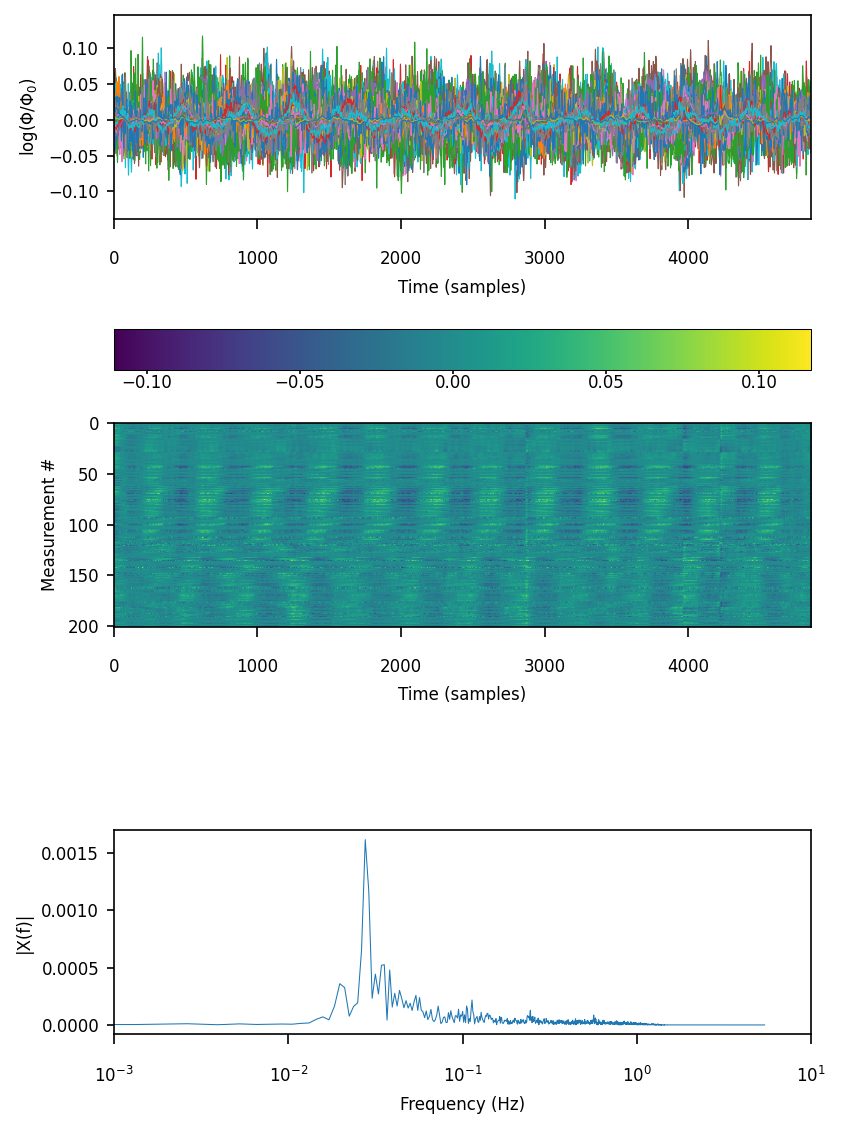

In [26]:
## Superficial Signal Regression
hem = tx4m.gethem(lp1data, info)
SSRdata, _ = tx4m.regcorr(lp1data, info, hem)

fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(SSRdata[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(SSRdata[keep,:]),1.25*np.amax(abs(SSRdata[keep,:]))])
ax1.set_xlim([0, len(SSRdata[keep][1])])

im2 = ax2.imshow(SSRdata[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(SSRdata[keep,:]),1), (len(np.mean(np.transpose(SSRdata[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%", 
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)

(0.001, 10)

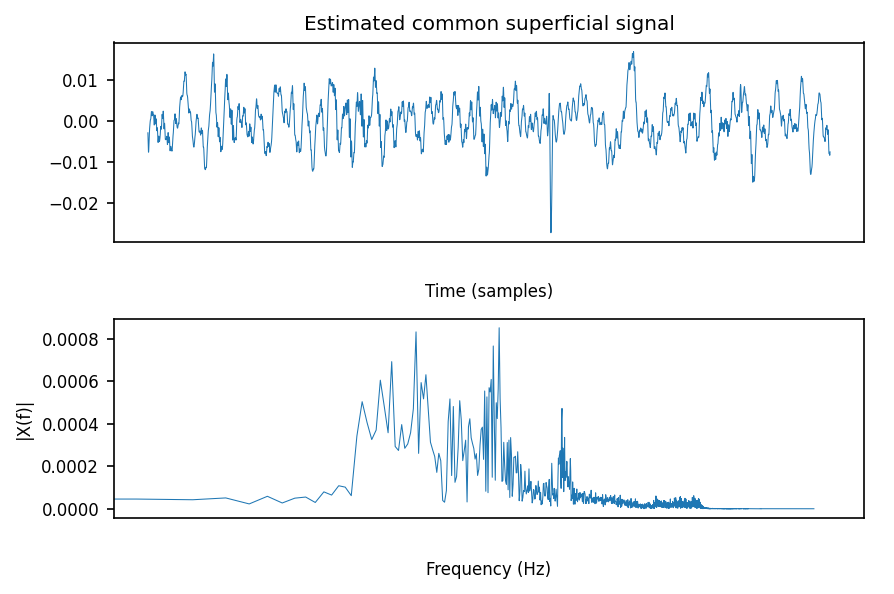

In [27]:
# Visualize Superficial Signal Time Trace and Power Spectrum
fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(2,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])

ax1.plot(hem[1,:], linewidth = 0.5)
ax1.set_title('Estimated common superficial signal')
ax1.set_xlabel('Time (samples)')

arr1 = hem[1,:]
arr = np.reshape(arr1, (1,np.size(arr1)))
ftdomain,ftmag,_,_ = tx4m.fft_tts(arr,info['system']['framerate']) 
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax2.semilogx(ftdomain,ftmag, linewidth = 0.5)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('|X(f)|') # plot vs. log frequency
ax2.set_xlim([1e-3, 10])

(2428.5, 3428.5)

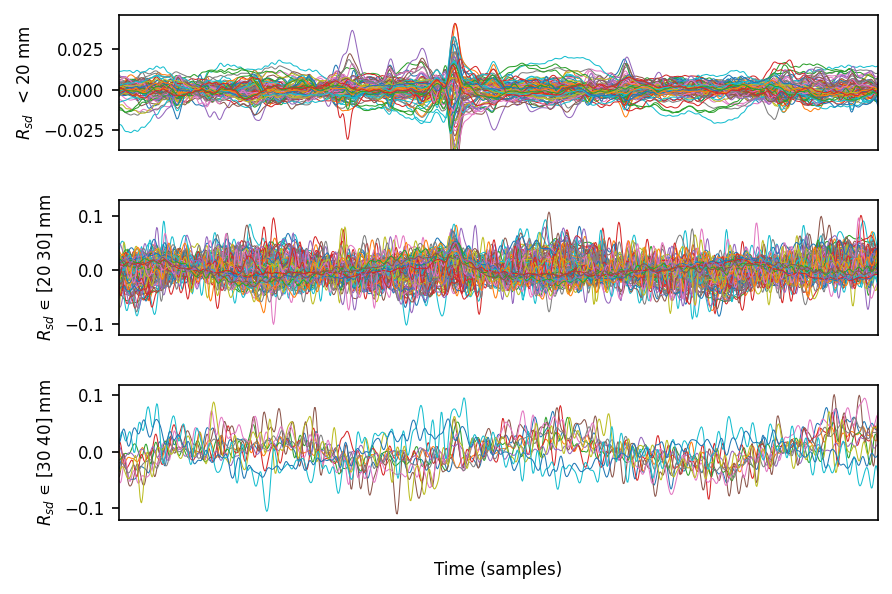

In [28]:
# Visualize Data after Superficial Signal Regression at different S-D distances
fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(SSRdata[keepd1,:]), linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$  < 20 mm')
ax1.set_xlim([np.shape(SSRdata[keepd1,:])[1]/2,(np.shape(SSRdata[keepd1,:])[1]/2 +1000)])
ax1.set_ylim([np.amin(SSRdata[keepd1,:])*0.5, np.amax(SSRdata[keepd1,:])*0.75])

ax2.plot(np.transpose(SSRdata[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([np.shape(SSRdata[keepd2,:])[1]/2,(np.shape(SSRdata[keepd2,:])[1]/2 +1000)])

ax3.plot(np.transpose(SSRdata[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([np.shape(SSRdata[keepd3,:])[1]/2,(np.shape(SSRdata[keepd3,:])[1]/2 +1000)])

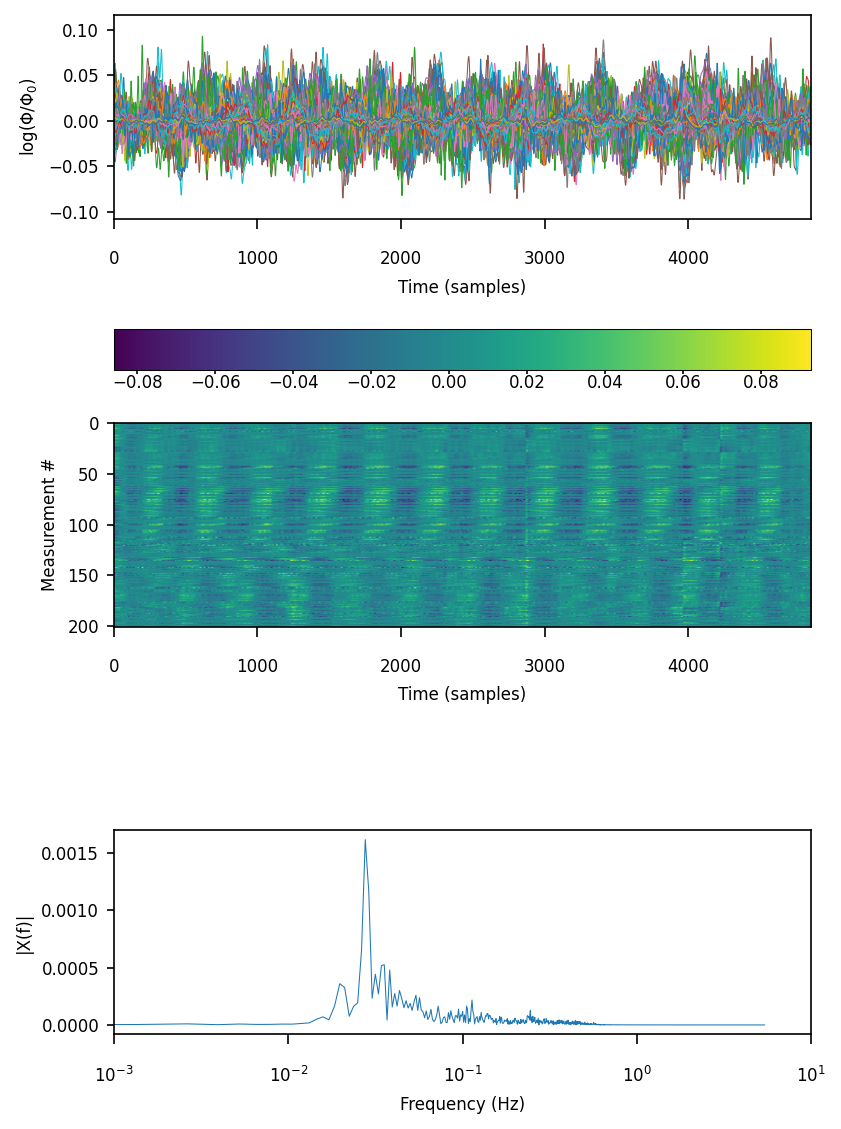

In [29]:
## Low Pass Filter 2
lp2data = tx4m.lowpass(SSRdata, 0.5, info['system']['framerate'])

# Generate 3 subplots
fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lp2data[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(lp2data[keep,:]),1.25*np.amax(abs(lp2data[keep,:]))])
ax1.set_xlim([0, len(lp2data[keep][1])])

im2 = ax2.imshow(lp2data[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(lp2data[keep,:]),1), (len(np.mean(np.transpose(lp2data[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%", 
                        height="20%",
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)


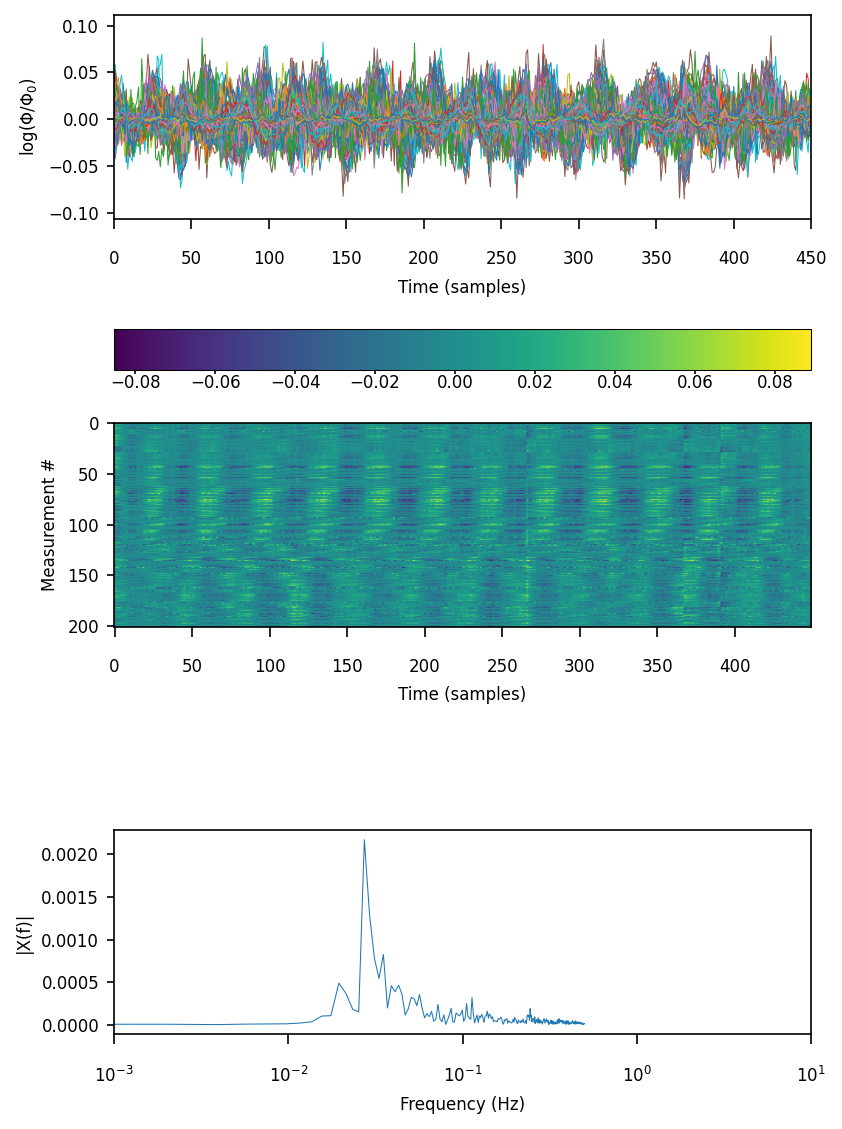

In [30]:
##Resampling
rdata, info = tx4m.resample_tts(lp2data, info, params['omega_resample'], params['rstol'])

# Generate 3 subplots
fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(rdata[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(rdata[keep,:]),1.25*np.amax(abs(rdata[keep,:]))])
ax1.set_xlim([0, len(rdata[keep][1])])

im2 = ax2.imshow(rdata[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(rdata[keep,:]),1), (len(np.mean(np.transpose(rdata[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%",  
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)


(225.0, 325.0)

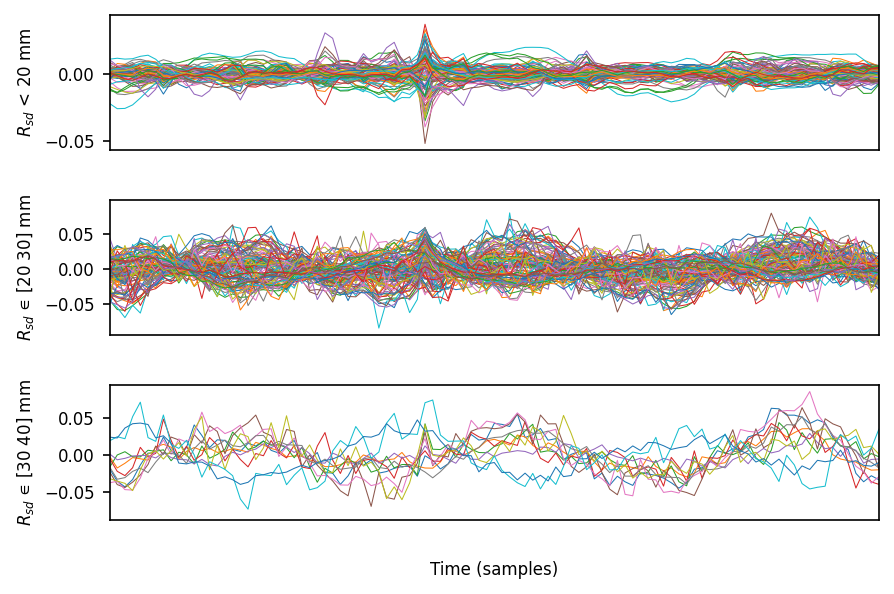

In [31]:
# Visualize Data after Resampling at different S-D distances
fig = plt.figure(dpi = 150, tight_layout = True, facecolor= 'white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(rdata[keepd1,:]),linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$ < 20 mm')
ax1.set_xlim([np.shape(rdata[keepd1,:])[1]/2,(np.shape(rdata[keepd1,:])[1]/2 +100)])

ax2.plot(np.transpose(rdata[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([np.shape(rdata[keepd2,:])[1]/2,(np.shape(rdata[keepd2,:])[1]/2 +100)])

ax3.plot(np.transpose(rdata[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([np.shape(rdata[keepd3,:])[1]/2,(np.shape(rdata[keepd3,:])[1]/2 +100)])

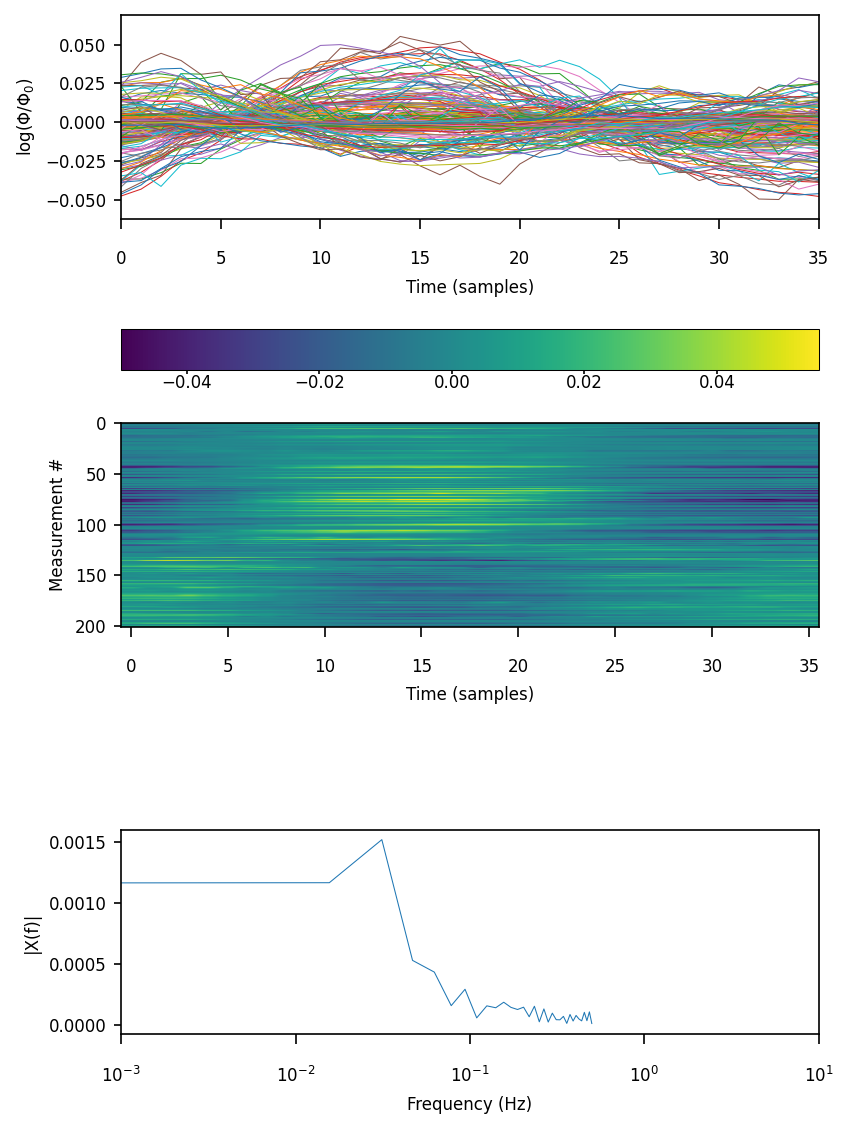

In [32]:
## Block Averaging
synchs = info['paradigm']['Pulse_2']-1
badata,_,_,_ = anlys.BlockAverage(rdata, info['paradigm']['synchpts'][synchs], 36)
keep = np.logical_and(np.logical_and(np.where(info['pairs']['WL'] == 2,1,0), np.where(info['pairs']['r2d'] < 40,1,0)), info['MEAS']['GI']) 

# Generate 3 subplots
fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(badata[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(badata[keep,:]),1.25*np.amax(abs(badata[keep,:]))])
ax1.set_xlim([0, len(badata[keep,:][1])-1])

im2 = ax2.imshow(badata[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(badata[keep,:]),1), (len(np.mean(np.transpose(badata[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%", 
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)

(0.0, 35.0)

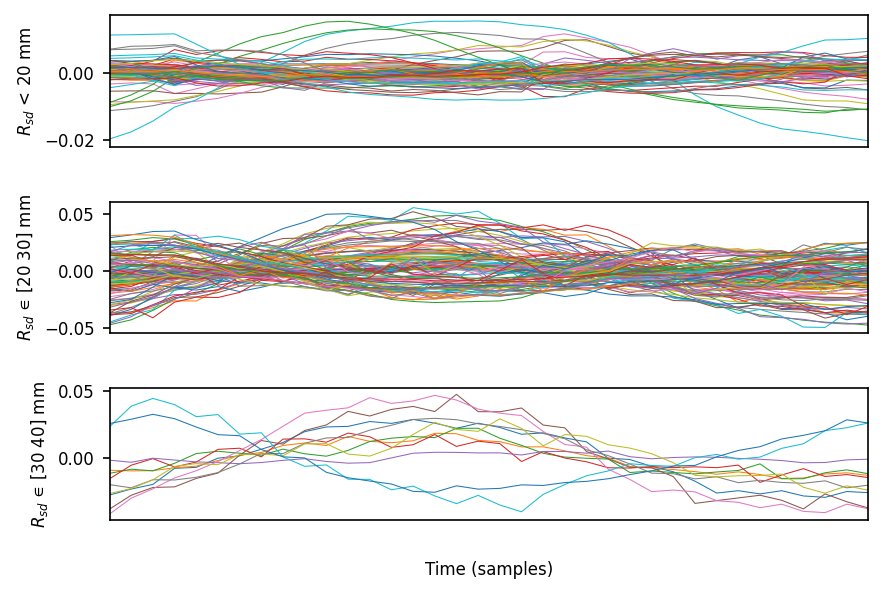

In [33]:
# Visualize Data after Block Averaging at different S-D distances
fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(badata[keepd1,:]), linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$ < 20 mm')
ax1.set_xlim([0, len(badata[keepd1,:][1])-1])

ax2.plot(np.transpose(badata[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([0, len(badata[keepd2,:][1])-1])

ax3.plot(np.transpose(badata[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([0, len(badata[keepd3,:][1])-1])


In [35]:
## RECONSTRUCTION PIPELINE
A = None
if A is None:
    A = {}
    if  "96x92" in A_fn:
        A['A'] = io.loadmat7p3(A_fn)['A']
        A['infoA'] = io.loadmat7p3(A_fn)['info']
        for key in A['infoA']['tissue']['dim']:
            if type(A['infoA']['tissue']['dim'][key]) == int or type(A['infoA']['tissue']['dim'][key]) == float :
                if np.size(A['infoA']['tissue']['dim'][key]) ==1:
                    A['infoA']['tissue']['dim'][key] = int(A['infoA']['tissue']['dim'][key])
    else:
        A['A'] = io.loadmat(A_fn)['A']
        A['infoA'] = io.loadmat(A_fn)['info']

    if len(A['A'].shape)>2:  # A data structure [wl X meas X vox]-->[meas X vox] # refer to matlab code for this
        Nwl = A['A'].shape[0]
        Nmeas = A['A'].shape[1]
        Nvox = A['A'].shape[2]
        A['A']=np.reshape(np.transpose(A['A'],(1,0,2)),Nwl*Nmeas,Nvox) # Changed permute to transpose 

Nvox= A['A'].shape[1]
Nt=rdata.shape[1]
cortex_mu_a=np.zeros((Nvox,Nt,2))

for j in range(1,3): 
    keep = np.logical_and(np.logical_and(np.where(info['pairs']['WL'] == 
                                                  
                                                  j,1,0), np.where(info['pairs']['r2d'] <= 40,1,0)), info['MEAS']['GI']) 
    print('> Inverting A')                
    iA = recon.Tikhonov_invert_Amat(A['A'][keep, :], 0.01, 0.1)                 # Invert A-Matrix
    print('> Smoothing iA')
    iA = recon.smooth_Amat(iA, A['infoA']['tissue']['dim'], 2)                  # Smooth Inverted A-Matrix      
    cortex_mu_a[:, :, j-1] = recon.reconstruct_img(rdata[keep, :], iA)  # Reconstruct Image Volume 

# Spectroscopy
Emat = '/Project/E_matrices/E.mat' 
if E is None:    
    E = io.loadmat(Emat)['E']
cortex_Hb = recon.spectroscopy_img(cortex_mu_a, E) 
cortex_HbO = cortex_Hb[:, :, 0]
cortex_HbR = cortex_Hb[:, :, 1]
cortex_HbT = cortex_HbO + cortex_HbR


FileNotFoundError: [Errno 2] No such file or directory: '/Project/A_matrices/A_AdultV24x28.mat'

In [ ]:
## Select Volumetric visualizations of block averaged data
MNI_file = '/Project/MNI_files/Segmented_MNI152nl_on_MNI111_py'
if MNI is None:   
    MNI=io.loadmat(MNI_file)['vol'] # load MRI (same data set as in A matrix dim)
    infoB=io.loadmat(MNI_file)['h']
MNI_dim = sx4m.affine3d_img(MNI,infoB,A['infoA']['tissue']['dim'],affine =np.eye(4),interp_type ='nearest') # transform to DOT volume space  


In [ ]:
# Flat Field Reconstruction
a=np.squeeze(A['A'][keep,:])

ffr = lmdl.makeFlatFieldRecon(a, iA)
fooV = sx4m.GoodVox2vol(ffr, A['infoA']['tissue']['dim'])
fooV = fooV/np.amax(fooV)

Params_recon = {}
Params_recon['Th'] = {}
Params_recon['Scale']=1
Params_recon['Th']['P']=1e-2
Params_recon['Th']['N']=-Params_recon['Th']['P']
Params_recon['Cmap']='jet' 
Params_recon['slices'] = [34,5,12]

viz.PlotSlices(MNI_dim, infoB, params = Params_recon, overlay = fooV) # set coordinates manually and save image in XNAT container 
plt.close() 

In [ ]:
# Visualize Block Averaged Data
badata_HbO = anlys.BlockAverage(cortex_HbO, info['paradigm']['synchpts'][info['paradigm']['Pulse_2']-1], params['dt'])[0]

badata_HbO= badata_HbO - badata_HbO[:,0, None]

badata_HbOvol = sx4m.GoodVox2vol(badata_HbO,A['infoA']['tissue']['dim'])

Params_recon = {}
Params_recon['Th'] = {}
Params_recon['Scale']=0.8*np.amax(abs(badata_HbOvol)) 
Params_recon['Th']['P']= 0.2*Params_recon['Scale']
Params_recon['Th']['N']=-0.2*Params_recon['Scale']#-Params_recon['Th']['P']
Params_recon['Cmap']='jet' 

#Uncomment the lines below if you want to see the interactive graph. 
# %matplotlib
# plt.ion()

# viz.PlotSlicesTimeTrace(MNI_dim,A['infoA']['tissue']['dim'],Params_recon,badata_HbOvol,info)
# plt.close()

In [ ]:
## Visualize block-averaged absorption and HbR, HbT data 
# use either of the next two lines to select mu_a (wavelength of 1 or 2 in the third
# dimension) or HbO, HbR, or HbT (second line)
# badata_HbO = anlys.BlockAverage(cortex_mu_a[:,:,1], info['paradigm']['synchpts'][info['paradigm']['Pulse_2]], info['dt'])
badata_HbT = anlys.BlockAverage(cortex_HbT, info['paradigm']['synchpts'][info['paradigm']['Pulse_2']-1], params['dt'])[0]
first_col = badata_HbT[:,0]
badata_HbT= badata_HbT - first_col[:,None]
badata_HbTvol = sx4m.GoodVox2vol(badata_HbT,A['infoA']['tissue']['dim'])

Params_recon = {}
Params_recon['Th'] = {}
Params_recon['Scale']=0.8*np.amax(abs(badata_HbTvol))
Params_recon['Th']['P']=0.2*Params_recon['Scale']
Params_recon['Th']['N']=-Params_recon['Th']['P']
Params_recon['Cmap']='jet'

#Uncomment the lines below if you want to see the interactive graph. 
# viz.PlotSlicesTimeTrace(MNI_dim,A['infoA']['tissue']['dim'],Params_recon,badata_HbOvol,info)
# plt.close()


In [ ]:
MNIl = None
if MNIl is None:
    MNIl=io.loadmat('/Project/Coritcal_Meshes/MNI164k_big_py.mat')['MNIl']
    MNIr=io.loadmat('/Project/Coritcal_Meshes/MNI164k_big_py.mat')['MNIr']

HbO_atlas = sx4m.affine3d_img(badata_HbOvol,A['infoA']['tissue']['dim'], infoB, np.eye(4))
HbO_atlas = np.transpose(HbO_atlas,[1,2,3,0])
tp_Eg_atlas = np.squeeze(HbO_atlas[:,:,:,params['tp']])


In [ ]:
# Adjust Visualization Parameters and generate Surface Visualization
# Generates HTML file that will open in your browser
pS = Params_recon
pS['view'] = 'post'
pS['ctx'] = 'std'
pS['Scale']=0.3*np.amax(abs(badata_HbTvol))
pS['Th']['P']=1e-4*Params_recon['Scale']
pS['Th']['N']=-Params_recon['Th']['P']
viz.PlotInterpSurfMesh(tp_Eg_atlas, MNIl, MNIr, infoB, pS)

NameError: name 'Params_recon' is not defined